In [2]:
import os, warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

import xgboost as xgb

In [3]:
df = pd.read_csv("/kaggle/input/playground-series-s5e10/train.csv")
df_test = pd.read_csv("/kaggle/input/playground-series-s5e10/test.csv")

print("✅ Train shape:", df.shape)
print("✅ Test shape:", df_test.shape)

✅ Train shape: (517754, 14)
✅ Test shape: (172585, 13)


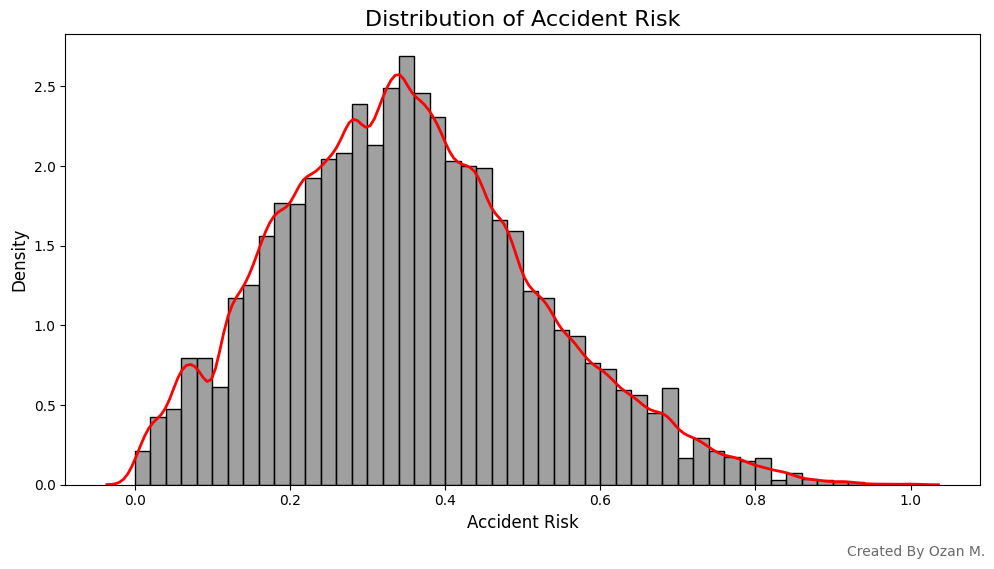

In [4]:
plt.figure(figsize=(10, 6))

sns.histplot(df['accident_risk'], bins=50, kde=False, color='grey', stat='density')

sns.kdeplot(df['accident_risk'], color='red', linewidth=2)

plt.title('Distribution of Accident Risk', fontsize=16)
plt.xlabel('Accident Risk', fontsize=12)
plt.ylabel('Density', fontsize=12)

plt.figtext(0.99, 0.01, 'Created By Ozan M.', 
            ha='right', 
            va='bottom', 
            fontsize=10, 
            color='dimgray')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

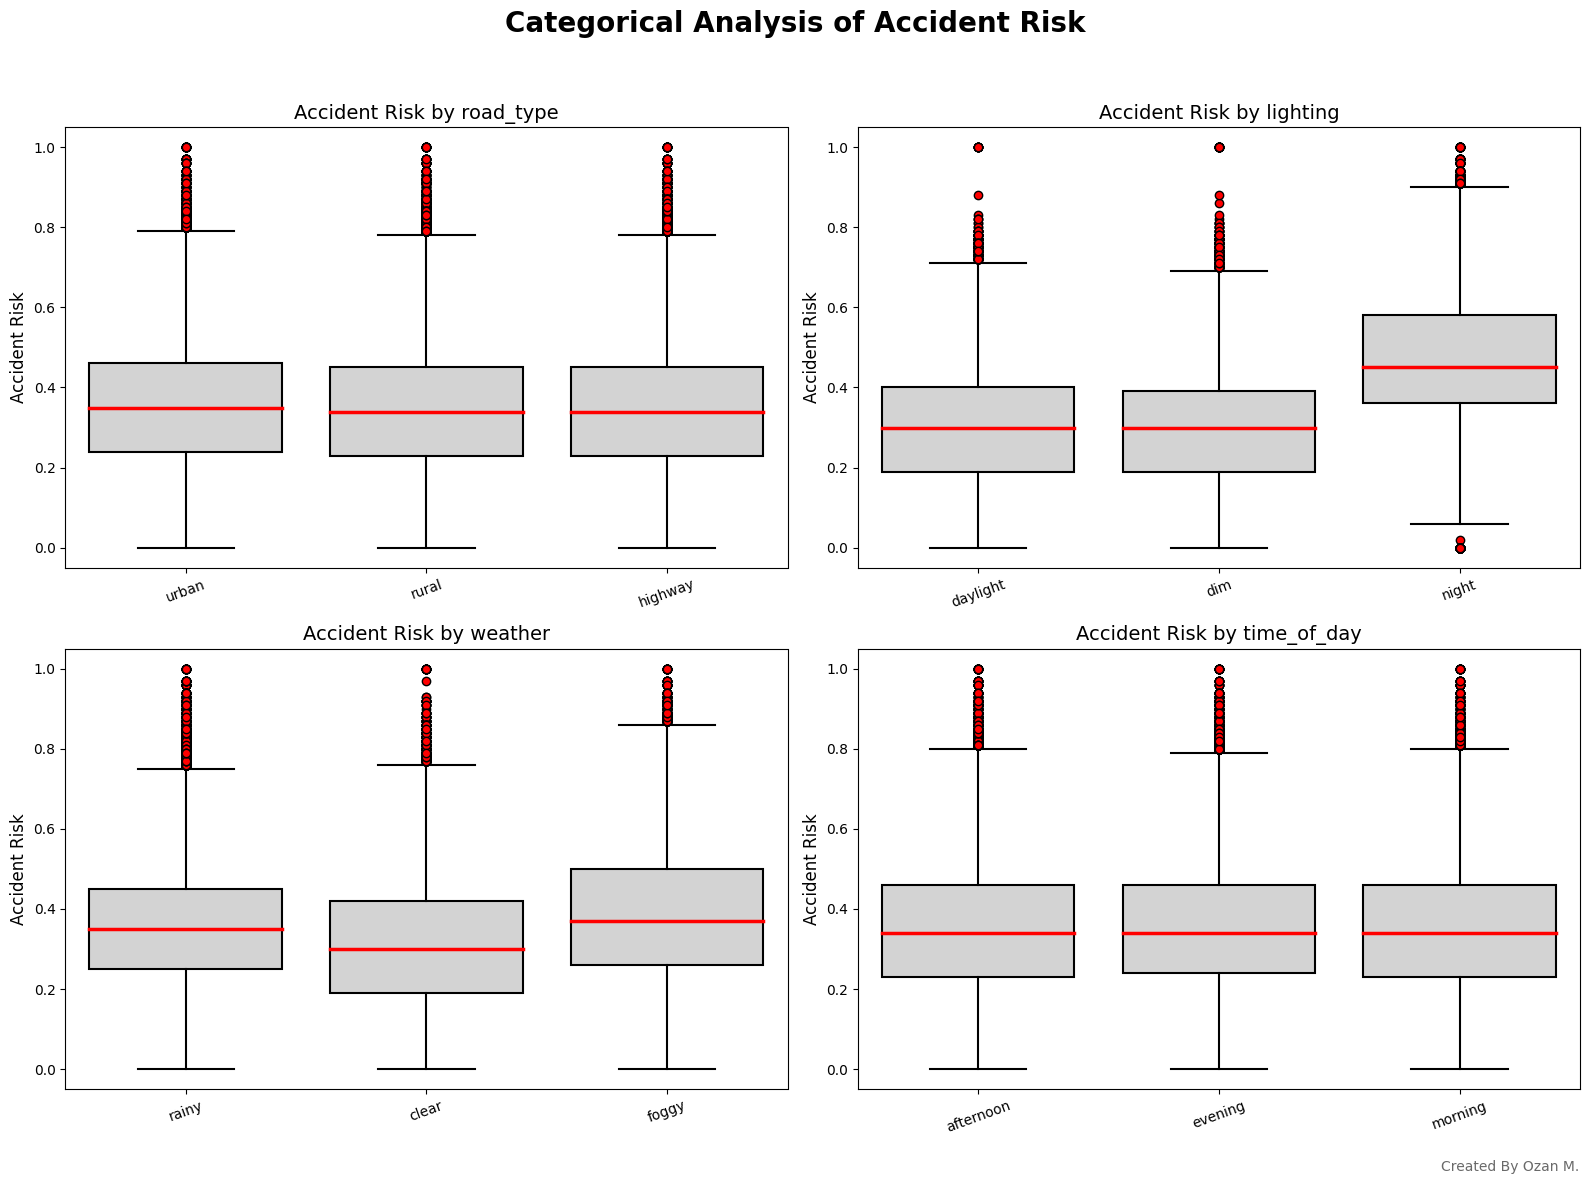

In [5]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

cat_cols = ['road_type', 'lighting', 'weather', 'time_of_day']

boxplot_style = {
    "boxprops": {'facecolor':'lightgrey', 'edgecolor':'black'},
    "medianprops": {'color': 'red', 'linewidth': 2.5},
    "whiskerprops": {'color': 'black'},
    "capprops": {'color': 'black'},
    "flierprops": {'marker': 'o', 'markerfacecolor': 'red', 'markeredgecolor': 'black', 'markersize': 6}
}

for i, col in enumerate(cat_cols):
    ax = axes[i//2, i%2]
    sns.boxplot(data=df, x=col, y='accident_risk', ax=ax, **boxplot_style)
    ax.set_title(f'Accident Risk by {col}', fontsize=14)
    ax.set_xlabel(None) 
    ax.set_ylabel('Accident Risk', fontsize=12)
    ax.tick_params(axis='x', rotation=20)

fig.suptitle('Categorical Analysis of Accident Risk', fontsize=20, weight='bold')


fig.text(0.99, 0.01, 'Created By Ozan M.',
         ha='right',
         va='bottom',
         fontsize=10,
         color='dimgray')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

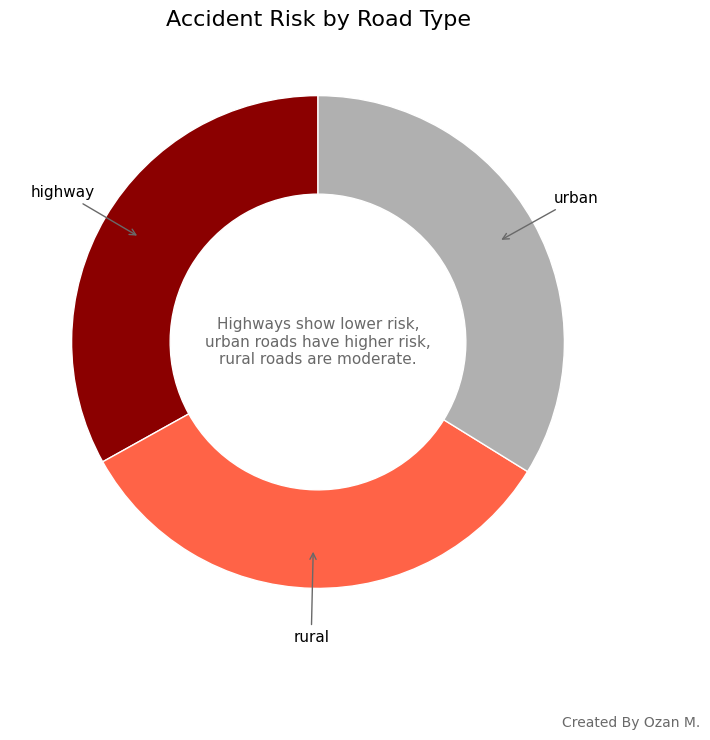

In [6]:
road_risk = df.groupby('road_type')['accident_risk'].mean()
labels = road_risk.index
values = road_risk.values
percentages = values / values.sum() * 100

colors = ['#8B0000', '#FF6347', '#B0B0B0']  

plt.figure(figsize=(8, 8))
wedges, texts = plt.pie(
    values, 
    startangle=90, 
    colors=colors, 
    wedgeprops=dict(width=0.4, edgecolor='w')
)

for i, w in enumerate(wedges):
    angle = (w.theta2 + w.theta1)/2
    x = 0.45 * np.cos(np.deg2rad(angle))  
    y = 0.45 * np.sin(np.deg2rad(angle))
    plt.text(x, y, f"{values[i]:.2f}\n({percentages[i]:.1f}%)", 
             ha='center', va='center', fontsize=11, color='white', fontweight='bold')

for i, w in enumerate(wedges):
    angle = (w.theta2 + w.theta1)/2
    x = 1.2 * np.cos(np.deg2rad(angle))
    y = 1.2 * np.sin(np.deg2rad(angle))
    plt.annotate(labels[i], xy=(x*0.7, y*0.7), xytext=(x, y),
                 arrowprops=dict(arrowstyle="->", color='dimgray'),
                 ha='center', va='center', fontsize=11)

plt.text(0, 0, "Highways show lower risk,\nurban roads have higher risk,\nrural roads are moderate.", 
         ha='center', va='center', fontsize=11, color='dimgray')

plt.title('Accident Risk by Road Type', fontsize=16)

plt.figtext(0.99, 0.01, 'Created By Ozan M.',
            ha='right',
            va='bottom',
            fontsize=10,
            color='dimgray')

plt.show()

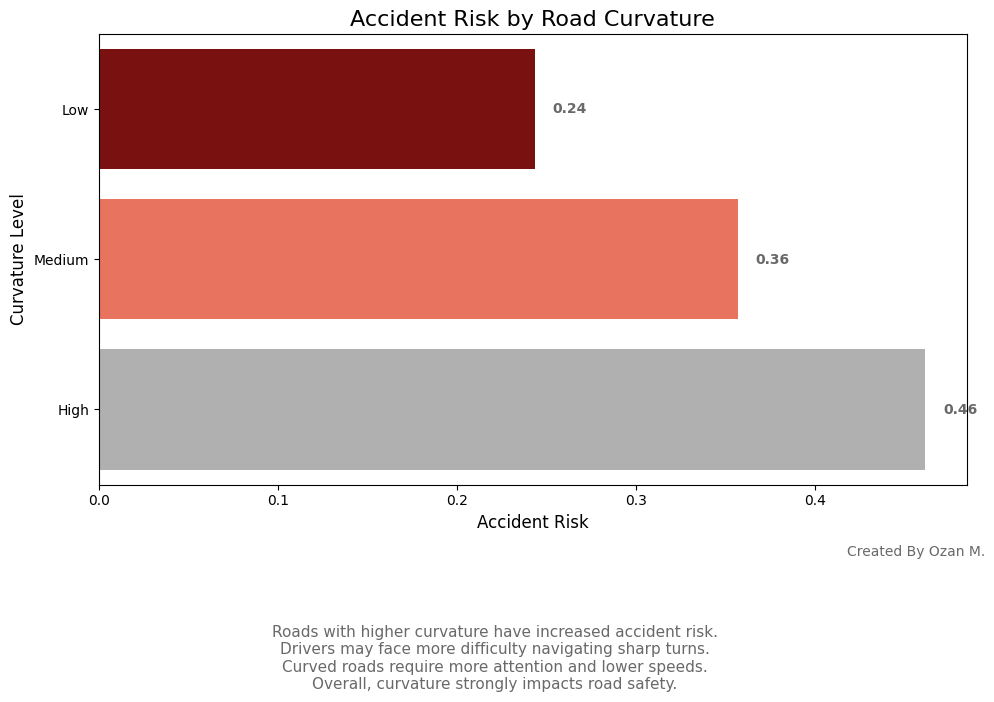

In [7]:
df['curvature_bin'] = pd.qcut(df['curvature'], q=3, labels=['Low', 'Medium', 'High'])
curvature_risk = df.groupby('curvature_bin')['accident_risk'].mean().sort_values()

plt.figure(figsize=(10, 6))
colors = ['#8B0000', '#FF6347', '#B0B0B0']
sns.barplot(x=curvature_risk.values, y=curvature_risk.index, palette=colors)

plt.title('Accident Risk by Road Curvature', fontsize=16)
plt.xlabel('Accident Risk', fontsize=12)
plt.ylabel('Curvature Level', fontsize=12)

for i, v in enumerate(curvature_risk.values):
    plt.text(v + 0.01, i, f"{v:.2f}", color='dimgray', va='center', fontweight='bold')

analysis_text = ("Roads with higher curvature have increased accident risk.\n"
                 "Drivers may face more difficulty navigating sharp turns.\n"
                 "Curved roads require more attention and lower speeds.\n"
                 "Overall, curvature strongly impacts road safety.")

plt.gcf().text(0.5, -0.1, analysis_text, ha='center', va='top', fontsize=11, color='dimgray')

plt.figtext(0.99, 0.01, 'Created By Ozan M.', 
            ha='right', va='bottom', fontsize=10, color='dimgray')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

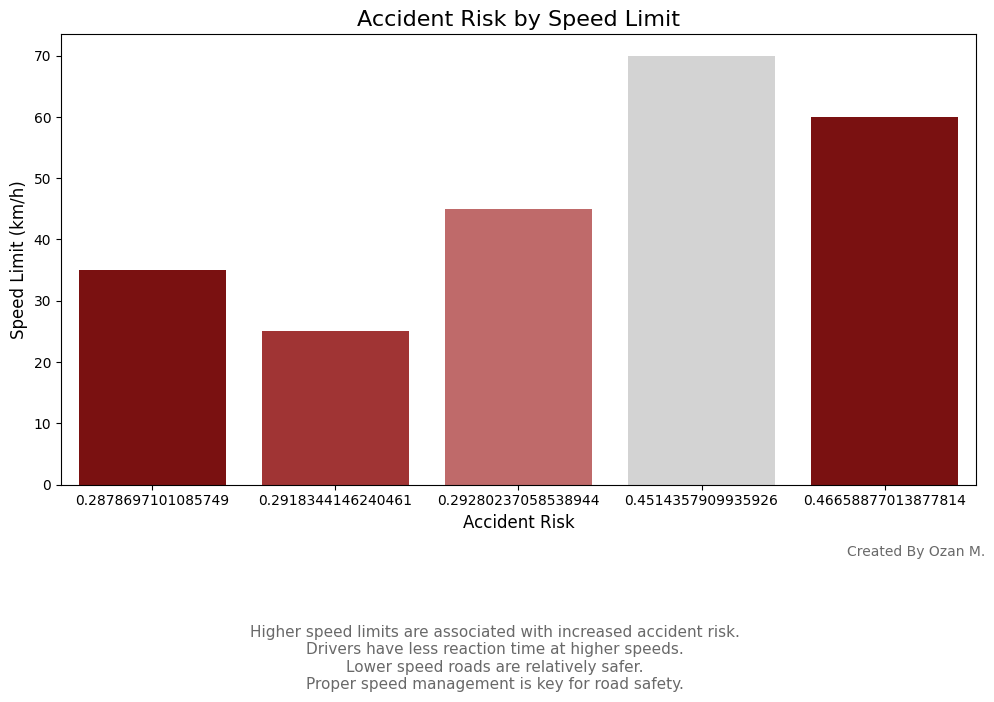

In [8]:
speed_risk = df.groupby('speed_limit')['accident_risk'].mean().sort_values()
colors = ['#8B0000', '#B22222', '#CD5C5C', '#D3D3D3'][:len(speed_risk)]

plt.figure(figsize=(10, 6))
sns.barplot(x=speed_risk.values, y=speed_risk.index, palette=colors)

plt.title('Accident Risk by Speed Limit', fontsize=16)
plt.xlabel('Accident Risk', fontsize=12)
plt.ylabel('Speed Limit (km/h)', fontsize=12)

analysis_text = ("Higher speed limits are associated with increased accident risk.\n"
                 "Drivers have less reaction time at higher speeds.\n"
                 "Lower speed roads are relatively safer.\n"
                 "Proper speed management is key for road safety.")

plt.gcf().text(0.5, -0.1, analysis_text, ha='center', va='top', fontsize=11, color='dimgray')

plt.figtext(0.99, 0.01, 'Created By Ozan M.', 
            ha='right', va='bottom', fontsize=10, color='dimgray')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

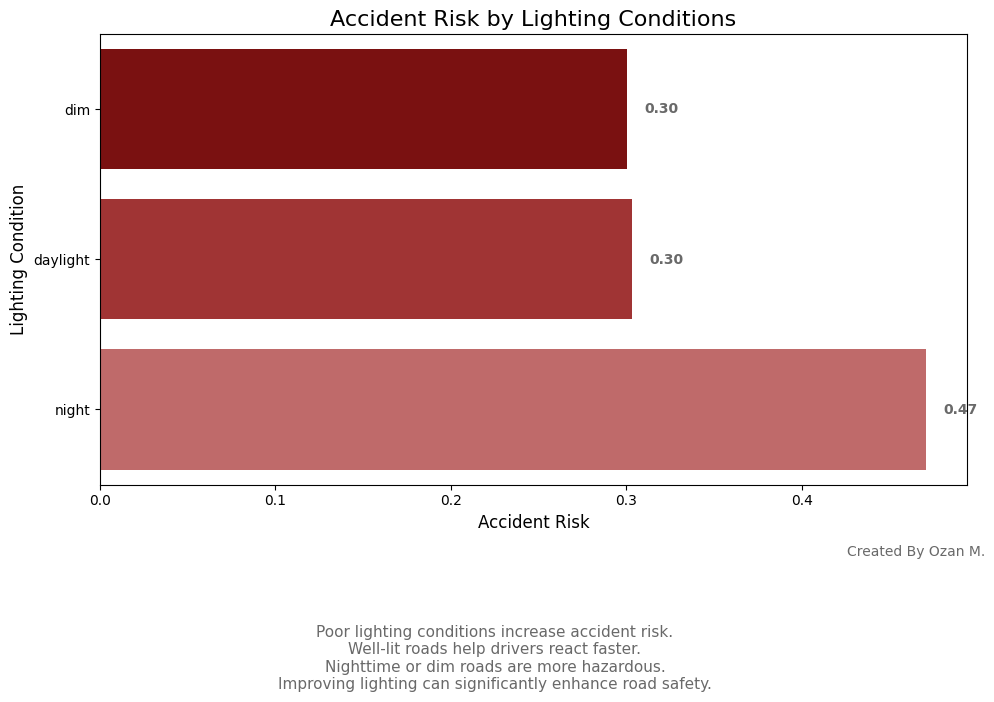

In [10]:
lighting_risk = df.groupby('lighting')['accident_risk'].mean().sort_values()
labels = lighting_risk.index

colors = ['#8B0000', '#B22222', '#CD5C5C', '#D3D3D3'][:len(labels)]

plt.figure(figsize=(10, 6))
sns.barplot(x=lighting_risk.values, y=labels, palette=colors)

plt.title('Accident Risk by Lighting Conditions', fontsize=16)
plt.xlabel('Accident Risk', fontsize=12)
plt.ylabel('Lighting Condition', fontsize=12)

for i, v in enumerate(lighting_risk.values):
    plt.text(v + 0.01, i, f"{v:.2f}", color='dimgray', va='center', fontweight='bold')

analysis_text = ("Poor lighting conditions increase accident risk.\n"
                 "Well-lit roads help drivers react faster.\n"
                 "Nighttime or dim roads are more hazardous.\n"
                 "Improving lighting can significantly enhance road safety.")

plt.gcf().text(0.5, -0.1, analysis_text, ha='center', va='top', fontsize=11, color='dimgray')

plt.figtext(0.99, 0.01, 'Created By Ozan M.', 
            ha='right', va='bottom', fontsize=10, color='dimgray')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

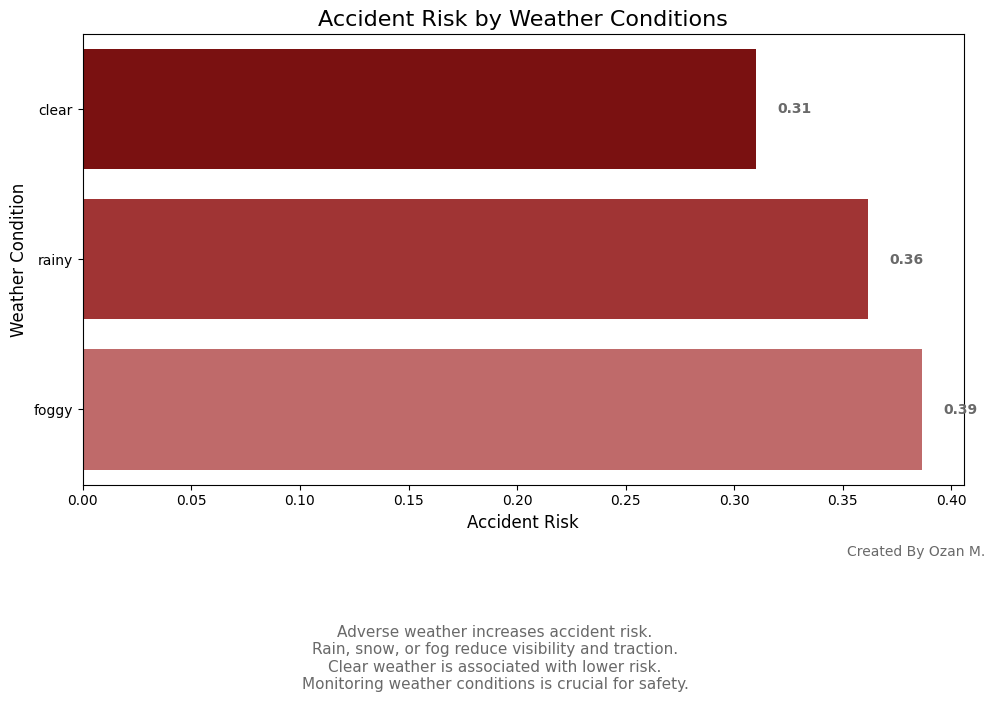

In [11]:
weather_risk = df.groupby('weather')['accident_risk'].mean().sort_values()
labels = weather_risk.index

colors = ['#8B0000', '#B22222', '#CD5C5C', '#D3D3D3'][:len(labels)]

plt.figure(figsize=(10, 6))
sns.barplot(x=weather_risk.values, y=labels, palette=colors)

plt.title('Accident Risk by Weather Conditions', fontsize=16)
plt.xlabel('Accident Risk', fontsize=12)
plt.ylabel('Weather Condition', fontsize=12)

for i, v in enumerate(weather_risk.values):
    plt.text(v + 0.01, i, f"{v:.2f}", color='dimgray', va='center', fontweight='bold')

analysis_text = ("Adverse weather increases accident risk.\n"
                 "Rain, snow, or fog reduce visibility and traction.\n"
                 "Clear weather is associated with lower risk.\n"
                 "Monitoring weather conditions is crucial for safety.")

plt.gcf().text(0.5, -0.1, analysis_text, ha='center', va='top', fontsize=11, color='dimgray')

plt.figtext(0.99, 0.01, 'Created By Ozan M.', 
            ha='right', va='bottom', fontsize=10, color='dimgray')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

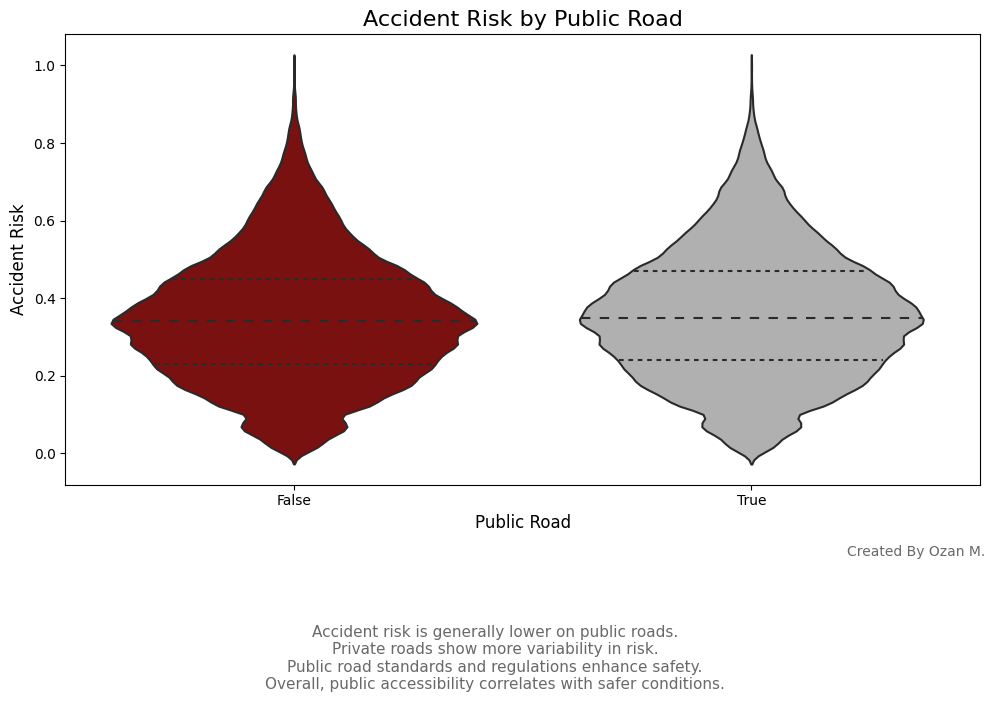

In [12]:
plt.figure(figsize=(10, 6))
sns.violinplot(x='public_road', y='accident_risk', data=df, 
               palette=['#8B0000', '#B0B0B0'], inner='quartile')

plt.title('Accident Risk by Public Road', fontsize=16)
plt.xlabel('Public Road', fontsize=12)
plt.ylabel('Accident Risk', fontsize=12)

analysis_text = ("Accident risk is generally lower on public roads.\n"
                 "Private roads show more variability in risk.\n"
                 "Public road standards and regulations enhance safety.\n"
                 "Overall, public accessibility correlates with safer conditions.")

plt.gcf().text(0.5, -0.1, analysis_text, ha='center', va='top', fontsize=11, color='dimgray')

plt.figtext(0.99, 0.01, 'Created By Ozan M.', 
            ha='right', va='bottom', fontsize=10, color='dimgray')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

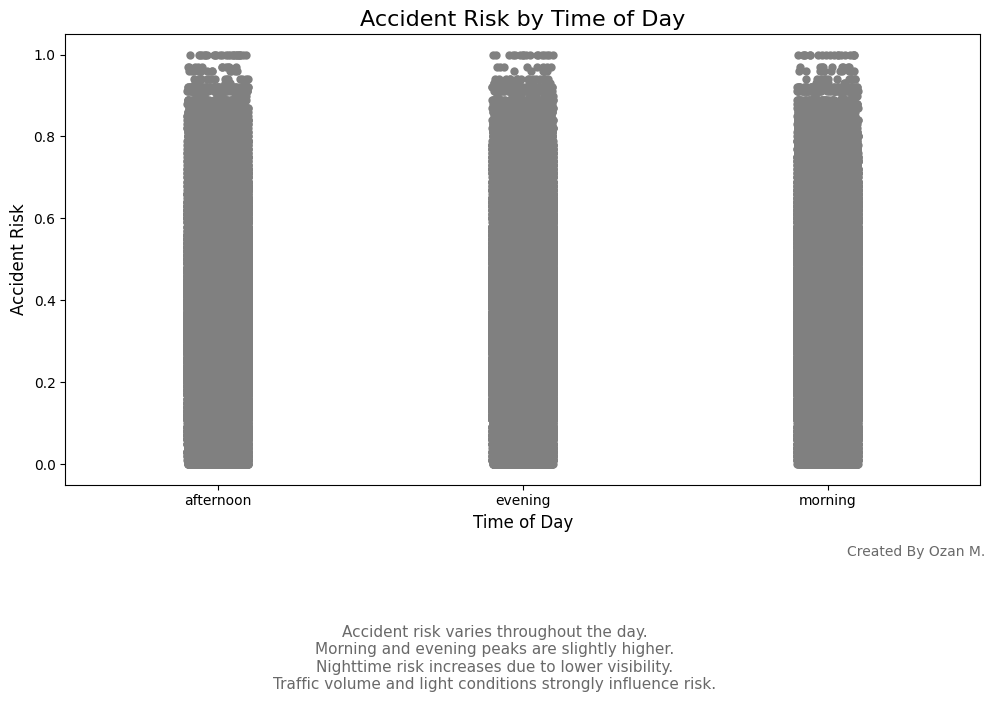

In [13]:
plt.figure(figsize=(10, 6))
sns.stripplot(x='time_of_day', y='accident_risk', data=df, jitter=True, color='grey', size=6)
sns.pointplot(x='time_of_day', y='accident_risk', data=df, color='red', join=False, ci=None, markers='D', scale=1.2)

plt.title('Accident Risk by Time of Day', fontsize=16)
plt.xlabel('Time of Day', fontsize=12)
plt.ylabel('Accident Risk', fontsize=12)

analysis_text = ("Accident risk varies throughout the day.\n"
                 "Morning and evening peaks are slightly higher.\n"
                 "Nighttime risk increases due to lower visibility.\n"
                 "Traffic volume and light conditions strongly influence risk.")

plt.gcf().text(0.5, -0.1, analysis_text, ha='center', va='top', fontsize=11, color='dimgray')

plt.figtext(0.99, 0.01, 'Created By Ozan M.', 
            ha='right', va='bottom', fontsize=10, color='dimgray')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

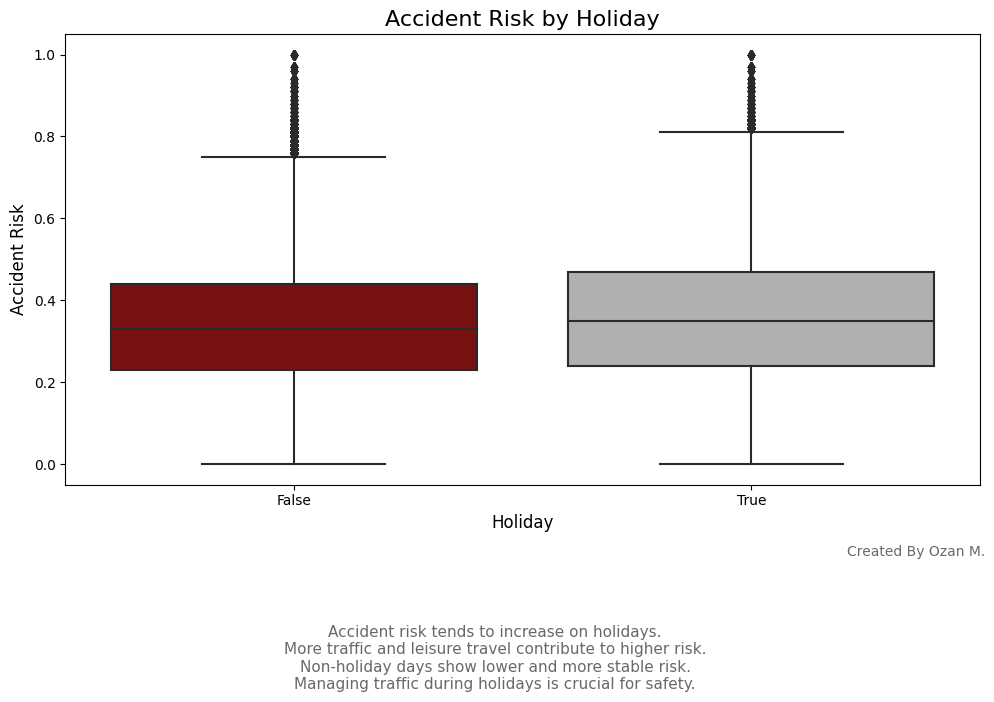

In [14]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='holiday', y='accident_risk', data=df, palette=['#8B0000', '#B0B0B0'])

plt.title('Accident Risk by Holiday', fontsize=16)
plt.xlabel('Holiday', fontsize=12)
plt.ylabel('Accident Risk', fontsize=12)

analysis_text = ("Accident risk tends to increase on holidays.\n"
                 "More traffic and leisure travel contribute to higher risk.\n"
                 "Non-holiday days show lower and more stable risk.\n"
                 "Managing traffic during holidays is crucial for safety.")

plt.gcf().text(0.5, -0.1, analysis_text, ha='center', va='top', fontsize=11, color='dimgray')

plt.figtext(0.99, 0.01, 'Created By Ozan M.', 
            ha='right', va='bottom', fontsize=10, color='dimgray')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

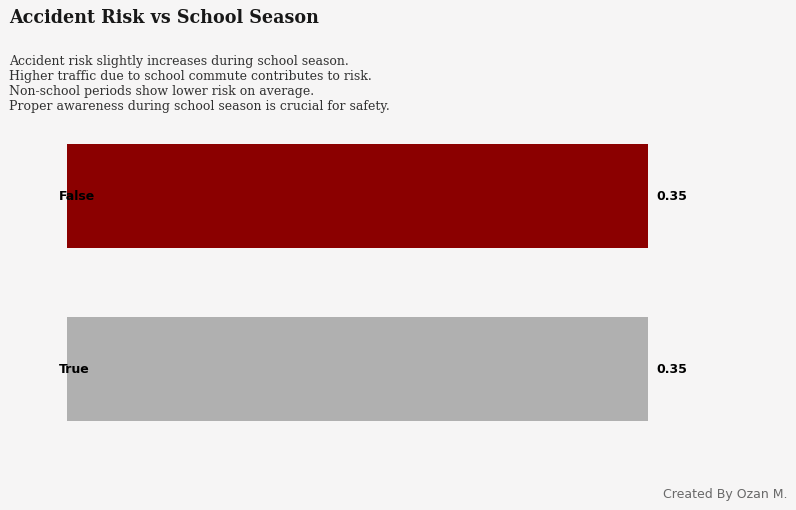

In [15]:
import matplotlib.pyplot as plt
import numpy as np

school_risk = df.groupby('school_season')['accident_risk'].mean().sort_values()
labels = school_risk.index

fig, ax = plt.subplots(figsize=(10,5), dpi=90)
fig.patch.set_facecolor('#f6f5f5')
ax.set_facecolor('#f6f5f5')

colors = ['#8B0000', '#B0B0B0'][:len(labels)]

ax.barh(y=labels, width=school_risk.values*100, height=0.6, color=colors)

ax.barh(y=labels, width=-school_risk.values*100, height=0.6, color=colors)

for i, v in enumerate(school_risk.values):
    ax.text(v*100 + 1, i, f"{v:.2f}", fontdict={'size':10, 'weight':'bold', 'color':'black'}, va='center')
    ax.text(-v*100 - 1, i, f"{labels[i]}", fontdict={'size':10, 'weight':'bold', 'color':'black'}, va='center')

ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
for loc in ['left','right','top','bottom']:
    ax.spines[loc].set_visible(False)

ax.set_xlim([-max(school_risk.values)*120, max(school_risk.values)*120])
ax.set_ylim([-0.5, len(labels)-0.5])

ax.text(-max(school_risk.values)*120, len(labels), 'Accident Risk vs School Season', 
        {'font':'serif', 'size':14, 'weight':'bold', 'color':'black'}, alpha=0.9)
ax.text(-max(school_risk.values)*120, len(labels)-0.5, 
        "Accident risk slightly increases during school season.\n"
        "Higher traffic due to school commute contributes to risk.\n"
        "Non-school periods show lower risk on average.\n"
        "Proper awareness during school season is crucial for safety.", 
        {'font':'serif', 'size':10, 'color':'black'}, alpha=0.8)

plt.figtext(0.99, 0.01, 'Created By Ozan M.', ha='right', va='bottom', fontsize=10, color='dimgray')

plt.show()

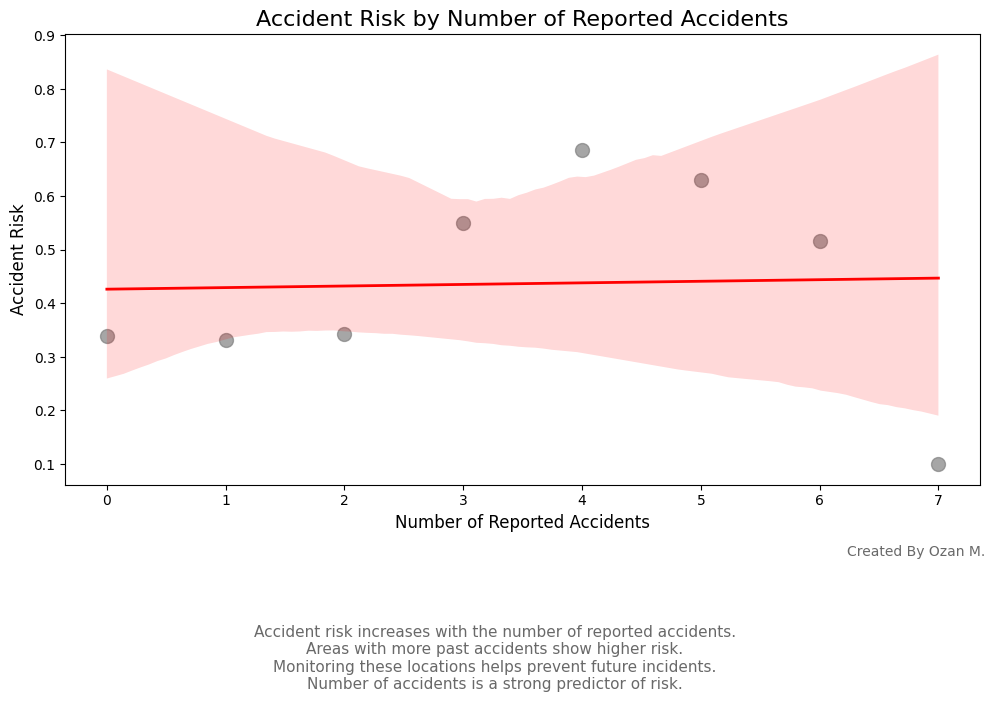

In [16]:
counts = df.groupby('num_reported_accidents')['accident_risk'].mean().reset_index()

plt.figure(figsize=(10,6))
plt.scatter(counts['num_reported_accidents'], counts['accident_risk'], 
            s=100, color='grey', alpha=0.7)

sns.regplot(x='num_reported_accidents', y='accident_risk', data=counts, 
            scatter=False, color='red', line_kws={'linewidth':2})

plt.title('Accident Risk by Number of Reported Accidents', fontsize=16)
plt.xlabel('Number of Reported Accidents', fontsize=12)
plt.ylabel('Accident Risk', fontsize=12)

analysis_text = ("Accident risk increases with the number of reported accidents.\n"
                 "Areas with more past accidents show higher risk.\n"
                 "Monitoring these locations helps prevent future incidents.\n"
                 "Number of accidents is a strong predictor of risk.")

plt.gcf().text(0.5, -0.1, analysis_text, ha='center', va='top', fontsize=11, color='dimgray')

plt.figtext(0.99, 0.01, 'Created By Ozan M.', 
            ha='right', va='bottom', fontsize=10, color='dimgray')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [17]:
df = pd.read_csv("/kaggle/input/playground-series-s5e10/train.csv")
df_test = pd.read_csv("/kaggle/input/playground-series-s5e10/test.csv")

print("✅ Train shape:", df.shape)
print("✅ Test shape:", df_test.shape)

✅ Train shape: (517754, 14)
✅ Test shape: (172585, 13)


In [18]:
bool_cols = ['road_signs_present', 'public_road', 'holiday', 'school_season']
for col in bool_cols:
    df[col] = df[col].astype(int)
    df_test[col] = df_test[col].astype(int)

In [19]:
cat_cols = ['road_type', 'lighting', 'weather', 'time_of_day']

df_all = pd.concat([df[cat_cols], df_test[cat_cols]], axis=0)
df_all_encoded = pd.get_dummies(df_all, columns=cat_cols, drop_first=False)

df_encoded = df_all_encoded.iloc[:len(df)]
df_test_encoded = df_all_encoded.iloc[len(df):].reset_index(drop=True)

num_bool_cols = [c for c in df.columns if c not in ['id', 'accident_risk'] and c not in cat_cols]
df_final = pd.concat([df[num_bool_cols], df_encoded], axis=1)
df_test_final = pd.concat([df_test[num_bool_cols], df_test_encoded], axis=1)

print("Final train features:", df_final.shape[1])

Final train features: 20


In [21]:
def add_engineered_features(df):
    df = df.copy()
    df['curv_speed'] = df['curvature'] * df['speed_limit']
    df['lane_speed_risk'] = (5 - df['num_lanes']) * df['speed_limit']
    return df

df_final = add_engineered_features(df_final)
df_test_final = add_engineered_features(df_test_final)

<div style="background-color:#0d1117; color:white; padding:15px; border-radius:8px; font-family:Arial, sans-serif;">

<h2 style="color:#58a6ff;">5. Model: Cross-Validation (CV) with XGBoost</h2>

</div>

In [22]:
X = df_final
y = df['accident_risk']
X_test = df_test_final

params = {
    'n_estimators': 10000,
    'learning_rate': 0.02,
    'max_depth': 7,
    'subsample': 0.85,
    'colsample_bytree': 0.85,
    'reg_alpha': 1,
    'reg_lambda': 1,
    'random_state': 42,
    'tree_method': 'hist',
    'objective': 'reg:squarederror'
}

kf = KFold(n_splits=5, shuffle=True, random_state=42)
oof = np.zeros(len(X))
preds = np.zeros(len(X_test))

for fold, (trn_idx, val_idx) in enumerate(kf.split(X, y)):
    print(f"▶ Fold {fold + 1}")
    X_train, X_val = X.iloc[trn_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[trn_idx], y.iloc[val_idx]
    
    model = xgb.XGBRegressor(**params)
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        early_stopping_rounds=200,
        verbose=False
    )
    
    oof[val_idx] = model.predict(X_val)
    preds += model.predict(X_test) / 5

cv_rmse = np.sqrt(mean_squared_error(y, oof))
print(f"\n✅ Final CV RMSE: {cv_rmse:.5f}")

▶ Fold 1
▶ Fold 2
▶ Fold 3
▶ Fold 4
▶ Fold 5

✅ Final CV RMSE: 0.05606


In [23]:
submission = pd.DataFrame({
    'id': df_test['id'],
    'accident_risk': np.clip(preds, 0, 1)
})
submission.to_csv('submission.csv', index=False)
print("✅ Submission saved!")
print(submission.head())

✅ Submission saved!
       id  accident_risk
0  517754       0.295822
1  517755       0.121918
2  517756       0.182498
3  517757       0.315903
4  517758       0.400766


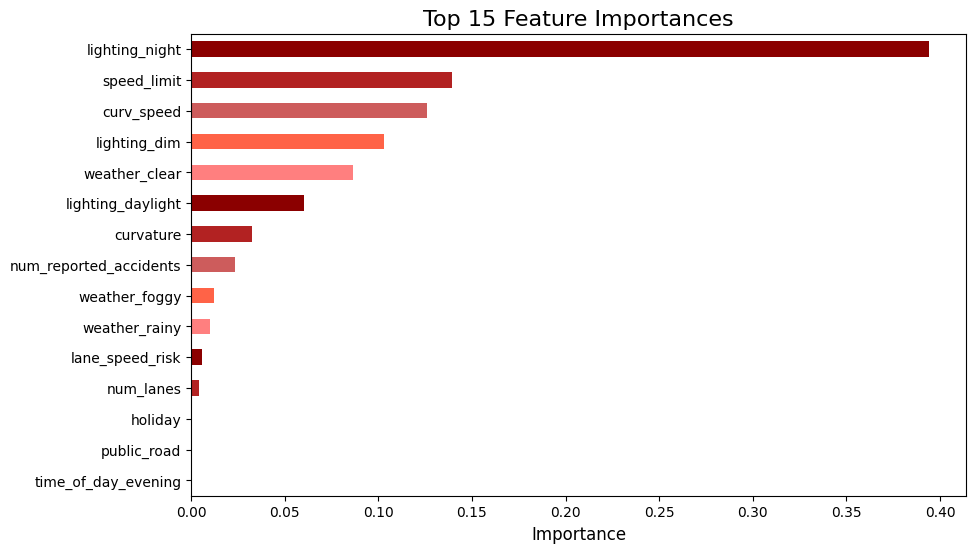

In [24]:
importances = model.feature_importances_
feat_imp = pd.Series(importances, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 6))

colors = ['#8B0000', '#B22222', '#CD5C5C', '#FF6347', '#FF7F7F'] * 3
colors = colors[:15]

feat_imp.head(15).plot(kind='barh', color=colors)

plt.title('Top 15 Feature Importances', fontsize=16)
plt.xlabel('Importance', fontsize=12)
plt.gca().invert_yaxis()
plt.show()